# Modeling Cross Section Data with KNN, DT, and Random Forest

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import natsort

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_style("white")

In [2]:
import sys
# This allows us to import the nucml utilities
sys.path.append("..")

import nucml.exfor.data_utilities as exfor_utils
import nucml.endf.data_utilities as endf_utils
import nucml.plot.plotting_utilities as plot_utils
import nucml.datasets as nuc_data
import nucml.ace.data_utilities as ace_utils
import nucml.model.model_building as model_building
import nucml.general_utilities as gen_utils

In [3]:
importlib.reload(exfor_utils)
importlib.reload(gen_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
importlib.reload(nuc_data)
importlib.reload(ace_utils)
importlib.reload(model_building)
print("Finish re-loading scripts.")

Finish re-loading scripts.


In [4]:
figure_dir = "../Figures/EXFOR_N/ACE/"

# Loading Normalized One-Hot Encoded Training, Validation, and Testing Datasets

In [5]:
df, x_train, x_test, y_train, y_test, to_scale, scaler = nuc_data.load_exfor(log=True, basic=0, num=True, low_en=True)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\EXFOR_neutrons\EXFOR_neutrons_MF3_AME_no_NaNRaw.csv
Reading data into dataframe...
 MODE: neutrons
 LOW ENERGY: True
 LOG: True
 BASIC: 0
Data read into dataframe with shape:  (4184245, 10)
Dropping unnecessary features and one-hot encoding categorical columns...
Splitting dataset into training and testing...
Normalizing dataset...
Finished. Resulting dataset has shape  (4184245, 49) 
Training and Testing dataset shapes are (3765820, 48) and (418425, 48) respesctively.


# Sampling Chlorine (n,p) and U-233(n,f) Data for Visualization

The model will be trained in the entire data therefore getting the total MSE. As an example, we will see the model predictions for both the mentioned reactions. 

In [5]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "scaler": scaler, "to_scale": to_scale}

chlorine_35_np = exfor_utils.load_exfor_samples(df, 17, 35, "MT_103", **kwargs)
uranium_235_nt = exfor_utils.load_exfor_samples(df, 92, 235, "MT_1", **kwargs)
uranium_233_nf = exfor_utils.load_exfor_samples(df, 92, 233, "MT_18", **kwargs)
uranium_233_nt = exfor_utils.load_exfor_samples(df, 92, 233, "MT_1", one_hot=True)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (40108, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (33384, 49)


In [6]:
kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "scaler": scaler, "to_scale": to_scale}
uranium = exfor_utils.load_exfor_element(df, 92, **kwargs)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (468123, 49)


# Newly Measured Chlorine (n,p) Unseen Data 

These data points are not in the current EXFOR data package and will be used to test the new modeling capabilities.

In [38]:
new_cl_data_kwargs = {"Z":17, "A":35, "MT":"MT_103", "log":True, "scale":True, "scaler":scaler, "to_scale":to_scale}
new_cl_data = exfor_utils.load_exfor_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, **new_cl_data_kwargs)
new_cl_data.head()

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (215, 49)
Scaling dataset...
Expanded Dataset has shape:  (12, 49)


,Energy,Data,Target_Protons,Target_Neutrons,Target_Mass_Number,MT_1,MT_102,MT_16,MT_17,MT_2,MT_3,MT_4,MT_101,MT_103,MT_104,MT_41,MT_9000,MT_105,MT_32,MT_51,MT_33,MT_107,MT_24,MT_155,MT_158,MT_159,MT_108,MT_29,MT_1108,MT_113,MT_106,MT_22,MT_1003,MT_9001,MT_28,MT_111,MT_203,MT_2103,MT_112,MT_37,MT_161,MT_152,MT_153,MT_18,MT_160,Frame_L,Frame_C,Target_Flag_I,Target_Flag_N
0,6.383815,-1.779892,-1.148362,-1.171466,-1.158608,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,6.383815,-1.707744,-1.148362,-1.171466,-1.158608,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,6.401401,-1.583359,-1.148362,-1.171466,-1.158608,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,6.401401,-1.590067,-1.148362,-1.171466,-1.158608,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,6.411620,-1.350665,-1.148362,-1.171466,-1.158608,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


# ENDF Evaluation Cross Section Data for Chlorine (n,p) Reaction

These data points will serve to plot the current ENDFb5 data and compare it to the newly measured points along with the predictions

In [8]:
endf_cl = nuc_data.load_endf("Cl035", "MT103", log=True)
endf_u  = nuc_data.load_endf("U233", "MT018", log=True)
endf_u_nonelastic  = nuc_data.load_endf("U233", "MT003", log=True)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\Cl035\endfb8.0\tables\xs\n-Cl035-MT103.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (8791, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT018.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (15345, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT003.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (33329, 2)


# Importing Error Metrics and Loading ACE Energy Arrays

In [9]:
ace_u = ace_utils.get_energies("92233") * 1E6
ace_cl = ace_utils.get_energies("17035") * 1E6

# Nearest Neighbors Regression

In [6]:
from joblib import dump, load

In [7]:
knn_results = pd.read_csv("../ML_Data/Models/KNN/knn_results.csv").sort_values(by="id")
dt_results = pd.read_csv("../ML_Data/Models/DT/dt_results.csv")

In [9]:
path_to_best_train_model_KNN = knn_results[knn_results.train_mae == knn_results.train_mae.min()]["model_path"].values[0]
print("Loading model saved at: {}".format(path_to_best_train_model_KNN))
train_model_knn = load(path_to_best_train_model_KNN) 

path_to_best_test_model_KNN = knn_results[knn_results.test_mae == knn_results.test_mae.min()]["model_path"].values[0]
print("Loading model saved at: {}".format(path_to_best_test_model_KNN))
test_model_knn = load(path_to_best_test_model_KNN) 

path_to_best_train_model_DT = dt_results[dt_results.train_mae == dt_results.train_mae.min()]["model_path"].values[0]
print("Loading model saved at: {}".format(path_to_best_train_model_DT))
train_model_dt = load(path_to_best_train_model_DT) 

path_to_best_test_model_DT = dt_results[dt_results.test_mae == dt_results.test_mae.min()]["model_path"].values[0]
print("Loading model saved at: {}".format(path_to_best_test_model_DT))
test_model_dt = load(path_to_best_test_model_DT) 

Loading model saved at: C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\Models\KNN\neigh_model_k18.joblib
Loading model saved at: C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\Models\KNN\neigh_model_k3.joblib
Loading model saved at: C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\Models\DT\dt_model_md300_mss2_msl1.joblib
Loading model saved at: C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\Models\DT\dt_model_md80_mss10_msl7.joblib


In [97]:
errors_exfor_ml = exfor_utils.get_mt_errors_exfor_ml(df, 92, 233, scaler, to_scale, train_model_dt)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (132828, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (33384, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (4588, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (261, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (2, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (5, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (7, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (11, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (3, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has s

In [98]:
errors_exfor_ml

,MT,MAE
0,MT_1,0.071657
0,MT_102,0.027254
0,MT_2,0.012790
0,MT_3,0.000000
0,MT_4,0.000000
0,MT_101,0.025348
0,MT_9000,0.000296
0,MT_51,0.060431
0,MT_18,0.025023


In [100]:
errors_exfor_endf = exfor_utils.get_mt_error_exfor_endf(df, 92, 233, scaler, to_scale)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (132828, 49)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (33384, 49)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT001.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (12617, 2)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (4588, 49)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT102.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (19513, 2)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (261, 49)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT002.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with sh

C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


 (3, 49)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT051.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (94, 2)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT018.endfb8.0
Converting MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (15345, 2)


In [101]:
errors_exfor_endf

,id,mae,mse,evs,mae_m,r2,MT
0,EXFOR VS ENDF,0.122255,0.053374,0.785871,0.051340,0.785843,MT_1
0,EXFOR VS ENDF,0.220991,0.119830,0.750434,0.140106,0.741655,MT_102
0,EXFOR VS ENDF,0.064535,0.005982,0.687744,0.060474,0.203517,MT_2
0,EXFOR VS ENDF,0.052568,0.004289,-0.315432,0.052568,-2.697823,MT_3
0,EXFOR VS ENDF,0.191249,0.040123,0.647989,0.158440,-2.981742,MT_4
0,EXFOR VS ENDF,0.112621,0.013708,0.569741,0.097065,0.436689,MT_51
0,EXFOR VS ENDF,0.091057,0.020448,0.946378,0.054106,0.945942,MT_18


# Predicting using ACE Energy Grid

to save are:

- MT102
- MT18
- MT1
- MT2
- MT3

In [126]:
importlib.reload(exfor_utils)

<module 'nucml.exfor.data_utilities' from '..\\nucml\\exfor\\data_utilities.py'>

In [136]:
ace_df = exfor_utils.get_csv_for_ace(df, 92, 233, scaler, to_scale, train_model_dt)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (132828, 49)
MT_1
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (33384, 49)
Expanded Dataset has shape:  (8742, 48)
Scaling dataset...
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (33384, 49)
MT_102
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (4588, 49)
Expanded Dataset has shape:  (8742, 48)
Scaling dataset...
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (4588, 49)
MT_2
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (261, 49)
Expanded Dataset has shape:  (8742, 48)
Scaling dataset...
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (261, 49)
MT_3
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (2, 49)
Expanded Dataset has shape:  (8742, 48)
Scaling dataset...
Extracting samples from dataframe.
EXFOR extracted D

In [137]:
ace_df = 10**ace_df

# ace_df["Energy"] = ace_df["Energy"] / 1E6

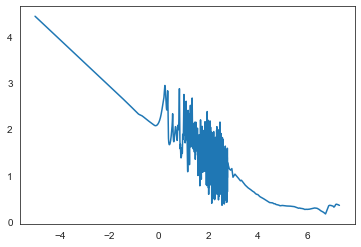

In [138]:
plt.plot(endf_mt18.Energy, endf_mt18.Data)

In [139]:
endf_mt18

,Energy,Data
0,-5.000000,4.431410
1,-4.986224,4.424521
2,-4.972451,4.417634
3,-4.958670,4.410747
4,-4.944901,4.403860
...,...,...
15340,7.278754,0.361803
15341,7.284839,0.360124
15342,7.290035,0.358666
15343,7.296119,0.356941


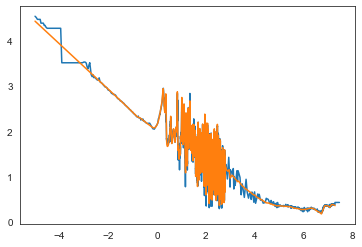

In [140]:
plt.plot(np.log10(ace_df.Energy), np.log10(ace_df.MT_18))
plt.plot(endf_mt18.Energy, endf_mt18.Data)

In [120]:
ace_df

,Energy,MT_1,MT_102,MT_2,MT_3,MT_4,MT_51,MT_18
0,1.000000e-11,34700.000,34700.000,34700.0000,34700.00,34700.00,34700.000000,34700.00
1,1.125000e-11,32500.000,32500.000,32500.0000,32500.00,32500.00,32500.000000,32500.00
2,1.250000e-11,29600.000,29600.000,29600.0000,29600.00,29600.00,29600.000000,29600.00
3,1.375000e-11,29600.000,29600.000,29600.0000,29600.00,29600.00,29600.000000,29600.00
4,1.500000e-11,29600.000,29600.000,29600.0000,29600.00,29600.00,29600.000000,29600.00
...,...,...,...,...,...,...,...,...
8737,2.800000e+01,6.031,0.058,2.5343,2.65,1.13,0.204529,2.66
8738,2.850000e+01,6.031,0.058,2.5343,2.65,1.13,0.204529,2.66
8739,2.900000e+01,6.031,0.058,2.5343,2.65,1.13,0.204529,2.66
8740,2.950000e+01,6.031,0.058,2.5343,2.65,1.13,0.204529,2.66


Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (94567, 49)
Expanded Dataset has shape:  (8742, 48)
Scaling dataset...
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (94567, 49)


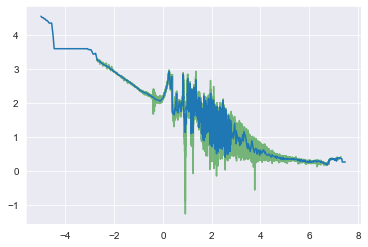

In [159]:
mt_18 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_18", df, neigh_all, 
                                              None, scaler, to_scale, log=True, show=True)

In [256]:
mt_102 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_102", df, neigh_all, 
                                               None, scaler, to_scale, log=True, show=True)

mt_1 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_1", df, neigh_all, None, 
                                             scaler, to_scale, log=True, show=True)
plt.show()
plt.close()
mt_2 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_2", df, neigh_all, 
                                             None, scaler, to_scale, log=True, show=True)
plt.show()
plt.close()
mt_3 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_3", df, neigh_all, 
                                             None, scaler, to_scale, log=True, show=True)
plt.plot(endf_u_nonelastic.Energy, endf_u_nonelastic.Data)

mt_101 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_101", df, neigh_all, 
                                               None, scaler, to_scale, log=True, show=True)

mt_1 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_1", df, neigh_all, None, 
                                             scaler, to_scale, log=True, show=True)
plt.show()
plt.close()
mt_2 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_2", df, neigh_all, 
                                             None, scaler, to_scale, log=True, show=True)
plt.show()
plt.close()
mt_3 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_3", df, neigh_all, 
                                             None, scaler, to_scale, log=True, show=True)
plt.plot(endf_u_nonelastic.Energy, endf_u_nonelastic.Data)

mt_101 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_101", df, neigh_all, 
                                               None, scaler, to_scale, log=True, show=True)

In [177]:
data_interest = pd.DataFrame({"Energy":ace_u})

data_interest["Data_18"] = mt_18
data_interest["Data_102"] = mt_102
data_interest["Data_1"] = mt_1
data_interest["Data_2"] = mt_2
data_interest["Data_3"] = mt_3

# data_interest.to_csv("U233_Data_ML.csv", index=False)

In [ ]:
# endf_mt1 = nuc_data.load_endf("U233", "MT001", log=True)
# endf_mt2  = nuc_data.load_endf("U233", "MT002", log=True)
# endf_mt3  = nuc_data.load_endf("U233", "MT003", log=True)
# endf_mt18 = nuc_data.load_endf("U233", "MT018", log=True)
# endf_mt101  = nuc_data.load_endf("U233", "MT101", log=True)
# endf_mt102  = nuc_data.load_endf("U233", "MT102", log=True)

# mt_18 = exfor_utils.make_predictions_from_df(92, 233, "MT_18", df, neigh_all, 
#                                               None, scaler, to_scale, log=True, show=True)

# plt.figure(figsize=(15,10))
# cl_mt_101 = exfor_utils.make_predictions_w_energy(ace_cl, 17, 35, "MT_103", df, neigh_all, 
#                                               None, scaler, to_scale, log=True, show=True)
# plt.plot(endf_cl.Energy, endf_cl.Data)